In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import pennylane as qml
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_cloud", 
                                  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/751efa30946d4936868b10697543fec5:158bef9c-3cc0-4872-bf46-72a10a914e1e::",
                                  token="65hk1wQlVKvQZNCnxm9PcCZXoPOyG9B2IPR1obcPNQOc", 
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()

In [7]:
backend = service.backend("ibm_torino") 

In [8]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
loc_test = np.load('loc_test.npy')

In [9]:
sample_indices = np.random.choice(len(X_test), 1000, replace=False)

X_test = X_test[sample_indices]
y_test = y_test[sample_indices]
loc_test = loc_test[sample_indices]

In [10]:
n_qubits = 4
n_layers = 3

In [11]:
from qiskit_aer.noise import NoiseModel

# Create a simple noise model
noise_model = NoiseModel.from_backend(backend)

dev = qml.device("qiskit.aer", wires=n_qubits, 
                 backend="aer_simulator", 
                 noise_model=noise_model, shots=1024)
                 
#dev = qml.device("qiskit.remote", wires=n_qubits, backend=backend)

In [12]:
@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    """A quantum circuit that acts as a feature extractor."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [13]:
class QLSTMModel(nn.Module):
    """
    Hybrid Quantum-Classical model for multi-step forecasting.
    A classical LSTM processes the sequence, and its output is fed
    into a quantum circuit for feature extraction, followed by a
    classical layer for multi-step prediction.
    """
    def __init__(self, n_features, n_lstm_units=4, n_qubits=2, num_layers=1, n_layers=1, output_len=72):
        super(QLSTMModel, self).__init__()

        # 1. Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True
        )
        
        # 2. Classical Layer to map LSTM output to Quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)
        
        # 3. Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(q_circuit, weight_shapes)
        
        # 4. Classical Layer to map quantum output to predictions
        self.quantum_to_output = nn.Linear(n_qubits, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Prepare the data for the quantum circuit
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # 4. Pass the features through the quantum circuit
        quantum_features = self.q_layer(quantum_input)
        
        # 5. Map quantum features to output sequence
        output = self.quantum_to_output(quantum_features)
        
        # 6. Apply sigmoid activation to get probabilities
        return torch.sigmoid(output)

In [14]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, 72 + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [15]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test, output_seq_len=72):
    """
    Evaluate the model with the needed metrics
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    preds_flat, labels_flat = all_preds.flatten(), all_labels.flatten()

    # All metrics Required
    accuracy = (preds_flat == labels_flat).mean()
    precision = precision_score(labels_flat, preds_flat, average="binary")
    recall = recall_score(labels_flat, preds_flat, average="binary")
    f1 = f1_score(labels_flat, preds_flat, average="binary")
    conf_matrix = confusion_matrix(labels_flat, preds_flat)

    # Per-location metrics
    unique_locations = np.unique(location_indices_test)
    location_metrics = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc, labels_loc = all_preds[idx].flatten(), all_labels[idx].flatten()
        location_metrics[int(loc)] = {
            "accuracy": (preds_loc == labels_loc).mean(),
            "precision": precision_score(labels_loc, preds_loc, average="binary"),
            "recall": recall_score(labels_loc, preds_loc, average="binary"),
            "f1": f1_score(labels_loc, preds_loc, average="binary"),
            "confusion_matrix": confusion_matrix(labels_loc, preds_loc)
        }

    # Per-hour metrics
    hour_metrics = []
    for hour in range(output_seq_len):
        preds_hour, labels_hour = all_preds[:, hour], all_labels[:, hour]
        hour_metrics.append({
            "hour": hour + 1,
            "accuracy": (preds_hour == labels_hour).mean(),
            "precision": precision_score(labels_hour, preds_hour, average="binary"),
            "recall": recall_score(labels_hour, preds_hour, average="binary"),
            "f1": f1_score(labels_hour, preds_hour, average="binary"),
            "confusion_matrix": confusion_matrix(labels_hour, preds_hour)
        })

    return {
        "overall": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": conf_matrix
        },
        "per_location": location_metrics,
        "per_hour": hour_metrics,
        "preds_flat": preds_flat,  
        "labels_flat": labels_flat  
    }

In [16]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [17]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [18]:
batch_size = 512
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
n_lstm_units = 32
num_layers = 1

model = QLSTMModel(
    n_features=9, 
    n_lstm_units=n_lstm_units,  
    n_qubits=n_qubits,
    num_layers=num_layers,
    n_layers=n_layers,
    output_len=72
)

try:
    model.load_state_dict(torch.load('best_qlstm_model_multistep.pth', weights_only=True))
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: Model file 'best_qlstm_model_multistep.pth' not found.")
    print("Please make sure the model training has been completed.")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

print("\nQuantum-Classical LSTM Model Architecture:")
print(model)

# Evaluate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model loaded successfully!

Quantum-Classical LSTM Model Architecture:
QLSTMModel(
  (lstm): LSTM(9, 32, batch_first=True)
  (classical_to_quantum): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)


QLSTMModel(
  (lstm): LSTM(9, 32, batch_first=True)
  (classical_to_quantum): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)

In [20]:
print("\nCalculating detailed accuracy metrics...")
with torch.no_grad():  
    metrics = evaluate_model_per_location_and_hour(
        model, test_loader, device, loc_test
    )


Calculating detailed accuracy metrics...


/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdelrahmane

In [21]:
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]


Per-location accuracy (averaged over all 72 hours):
Location 0: 0.9028
Location 1: 0.7778
Location 2: 0.8264
Location 4: 0.9236
Location 5: 0.8403
Location 6: 0.8333
Location 7: 0.8287
Location 8: 0.8313
Location 9: 0.7361
Location 10: 0.9167
Location 11: 0.8125
Location 12: 0.9167
Location 13: 0.7014
Location 14: 0.8056
Location 15: 0.8056
Location 16: 0.7130
Location 17: 0.6944
Location 18: 0.6736
Location 19: 0.8542
Location 20: 0.7500
Location 21: 0.8028
Location 22: 0.8241
Location 23: 0.9444
Location 24: 0.7130
Location 25: 0.8222
Location 26: 0.7639
Location 27: 0.9167
Location 28: 0.9120
Location 29: 0.6250
Location 30: 0.8750
Location 31: 0.8611
Location 32: 0.8194
Location 33: 0.8472
Location 34: 0.7639
Location 35: 0.8889
Location 36: 0.7500
Location 37: 0.6250
Location 38: 0.8750
Location 39: 0.7083
Location 40: 0.9398
Location 41: 0.5278
Location 42: 0.7639
Location 45: 0.8056
Location 46: 0.7014
Location 47: 0.8426
Location 48: 0.8750
Location 49: 1.0000
Location 50: 1.0

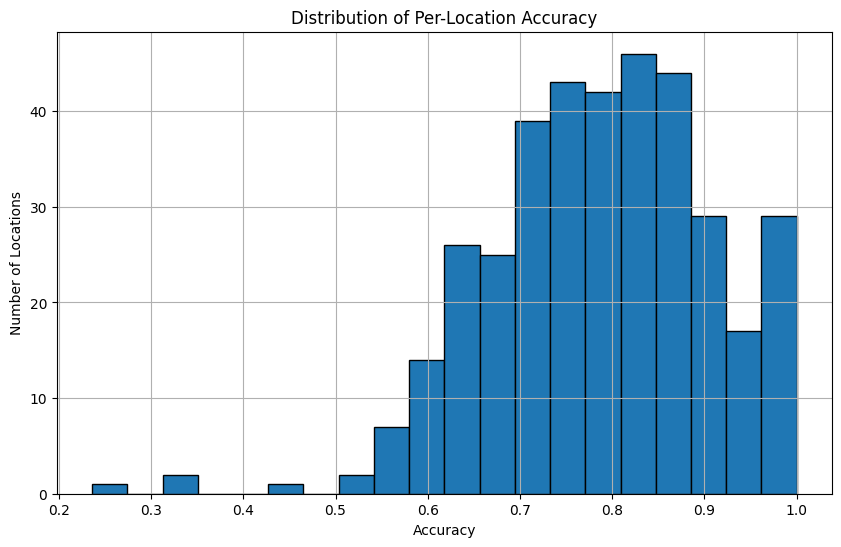

In [22]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_metrics.keys()):
    print(f"Location {loc}: {location_metrics[loc]['accuracy']:.4f}")

# Plot location accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist([loc_metrics['accuracy'] for loc_metrics in location_metrics.values()], bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Per-hour accuracy (averaged over all locations):
Hour 1: 0.9580
Hour 2: 0.9510
Hour 3: 0.9340
Hour 4: 0.9200
Hour 5: 0.9090
Hour 6: 0.8860
Hour 7: 0.8380
Hour 8: 0.8250
Hour 9: 0.8390
Hour 10: 0.8390
Hour 11: 0.8450
Hour 12: 0.8470
Hour 13: 0.8290
Hour 14: 0.8250
Hour 15: 0.8160
Hour 16: 0.8000
Hour 17: 0.7820
Hour 18: 0.7460
Hour 19: 0.7460
Hour 20: 0.7650
Hour 21: 0.7800
Hour 22: 0.7900
Hour 23: 0.8070
Hour 24: 0.8130
Hour 25: 0.8060
Hour 26: 0.7970
Hour 27: 0.7850
Hour 28: 0.7720
Hour 29: 0.7690
Hour 30: 0.7660
Hour 31: 0.7440
Hour 32: 0.7480
Hour 33: 0.7820
Hour 34: 0.7990
Hour 35: 0.8100
Hour 36: 0.8230
Hour 37: 0.7970
Hour 38: 0.7920
Hour 39: 0.7890
Hour 40: 0.7710
Hour 41: 0.7530
Hour 42: 0.7310
Hour 43: 0.7530
Hour 44: 0.7600
Hour 45: 0.7570
Hour 46: 0.7590
Hour 47: 0.7700
Hour 48: 0.7610
Hour 49: 0.7610
Hour 50: 0.7640
Hour 51: 0.7650
Hour 52: 0.7540
Hour 53: 0.7500
Hour 54: 0.7480
Hour 55: 0.7390
Hour 56: 0.7380
Hour 57: 0.7580
Hour 58: 0.7700
Hour 59: 0.7840
Hour 60: 0.7810

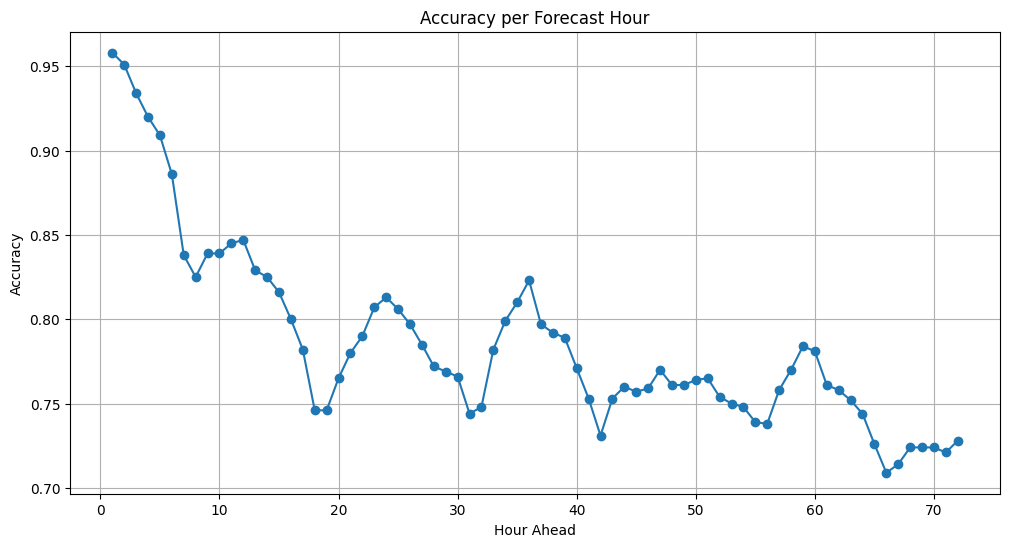

In [23]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour_metrics_dict in hour_metrics:
    hour = hour_metrics_dict["hour"]
    accuracy = hour_metrics_dict["accuracy"]
    print(f"Hour {hour}: {accuracy:.4f}")

# Plot hour accuracy
plt.figure(figsize=(12, 6))
plt.plot([hm["hour"] for hm in hour_metrics], [hm["accuracy"] for hm in hour_metrics], marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating detailed accuracy metrics...

Overall Confusion Matrix:


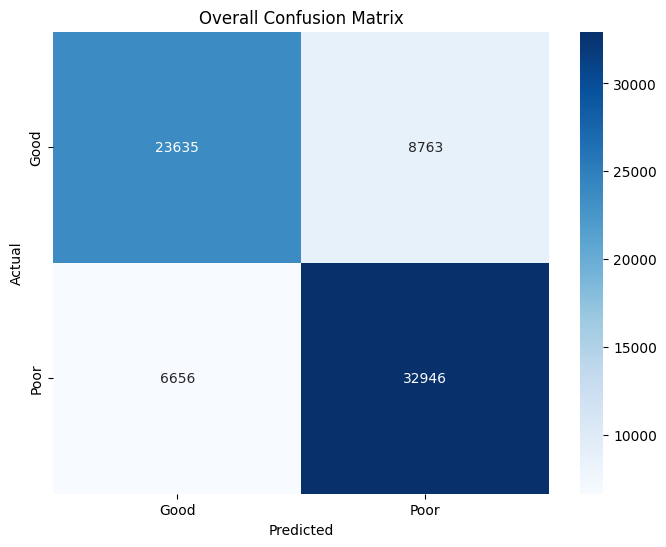


Overall Metrics:
Accuracy: 0.7858
Precision: 0.7899
Recall: 0.8319
F1 Score: 0.8104


In [24]:
# After getting metrics
print("\nCalculating detailed accuracy metrics...")

# Extract metrics
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]
preds_flat = metrics["preds_flat"]
labels_flat = metrics["labels_flat"]

# Plot overall confusion matrix
print("\nOverall Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(overall_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Good', 'Poor'],
            yticklabels=['Good', 'Poor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Overall Confusion Matrix')
plt.savefig('overall_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1 Score: {overall_metrics['f1']:.4f}")


Generating example predictions...


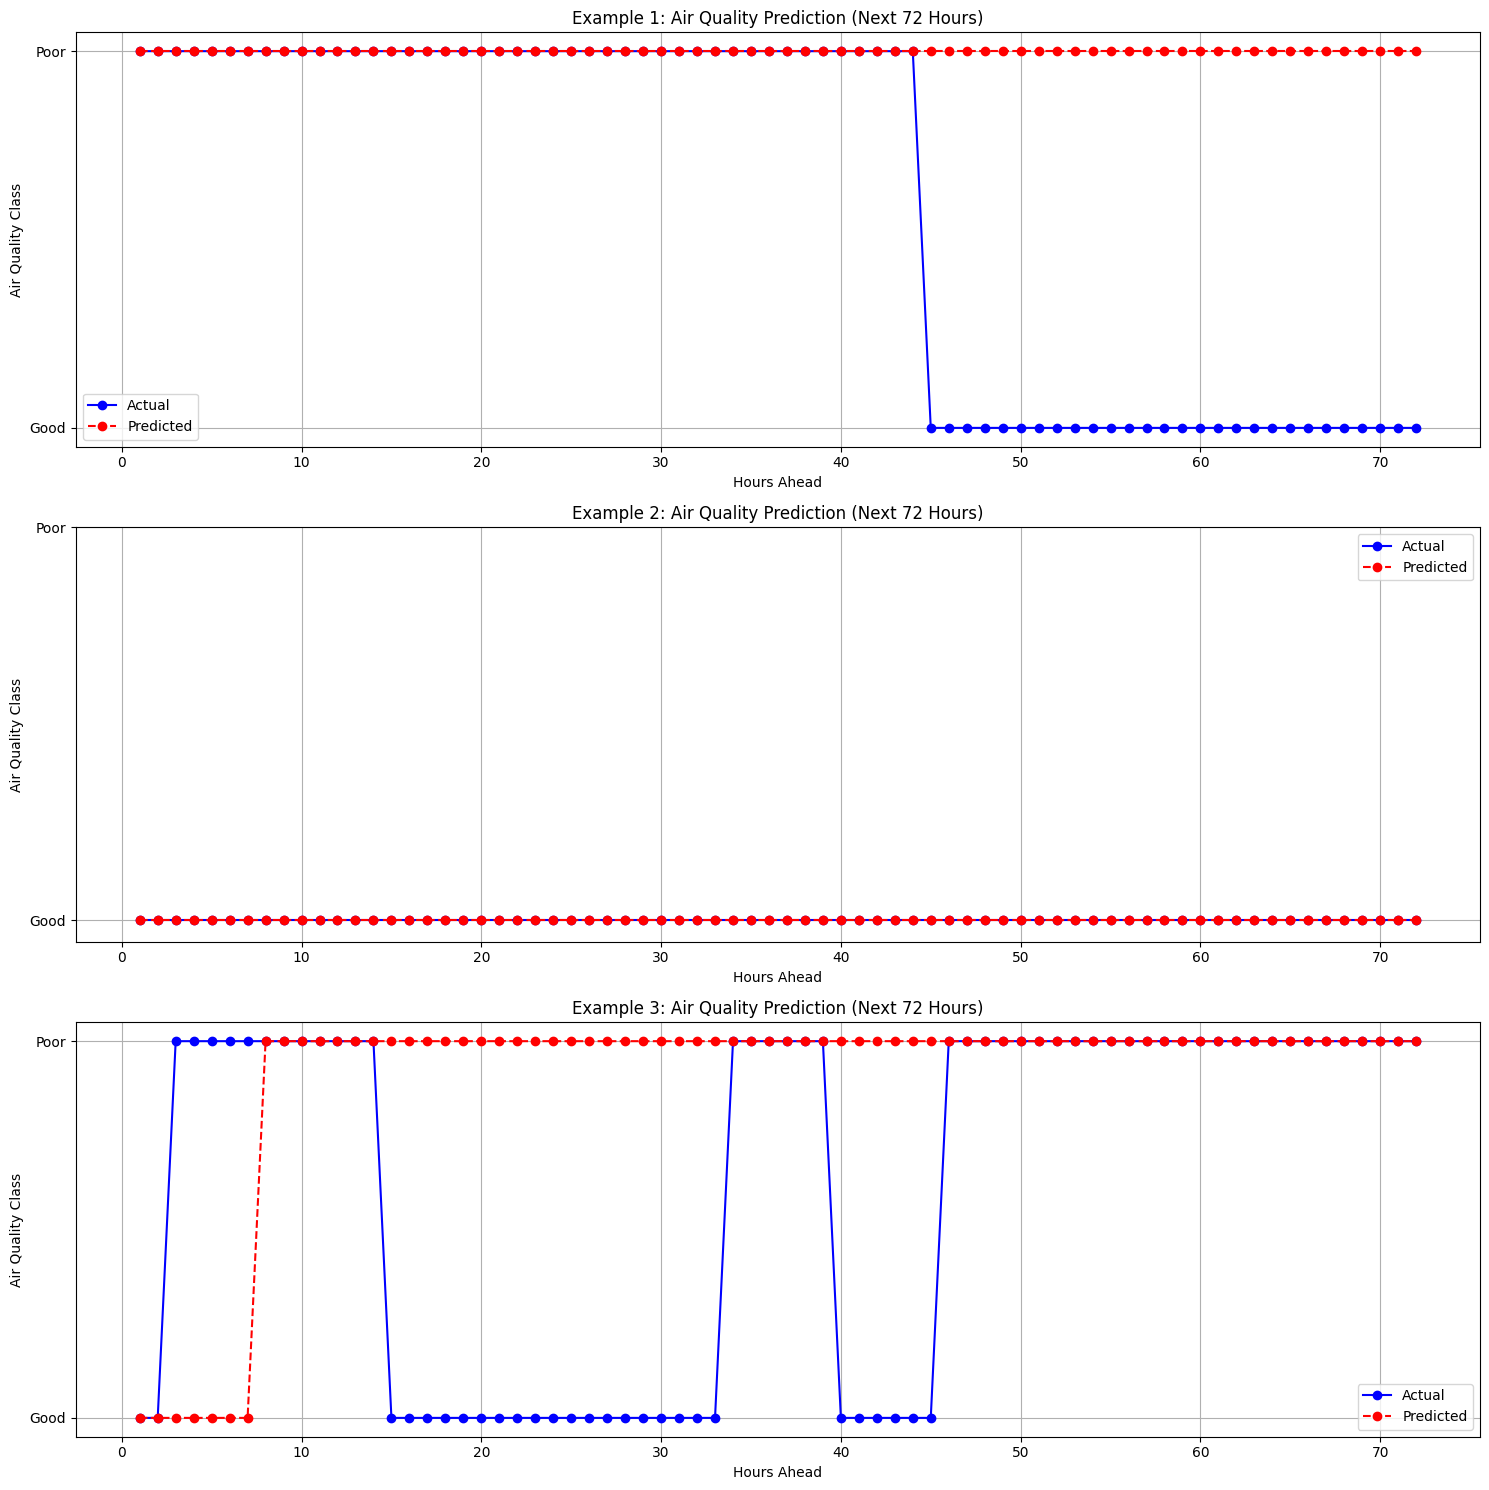


Testing complete. Results saved.


In [25]:
print("\nGenerating example predictions...")
plot_example_predictions(model, X_test, y_test, num_examples=3)

print("\nTesting complete. Results saved.")